In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# AE Arch

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        """
            Implement Encoder Network
            You can use convolutions, or linear or whatever. 
        """
        super(Encoder, self).__init__()
        self.linear1 = nn.Sequential(nn.Linear(64*64*3, 512), nn.PReLU())
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        """
            Implement Decoder Network
            You can use convolutions, or linear or whatever. 
        """
        super(Decoder, self).__init__()
        
        self.linear1 = nn.Sequential(nn.Linear(latent_dims, 512), nn.PReLU())
        self.linear2 = nn.Linear(512, 64*64*3)

    def forward(self, z):
        z = self.linear1(z)
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 64, 64))

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [6]:
from tqdm import tqdm

Архитектура AE, предложенная мной:

In [55]:
class My_Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2),
            nn.ReLU(True),
            nn.Conv2d(16, 64, 3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 256, 2, stride=2),
            nn.ReLU(True)
        )
        
        self.linear2 = nn.Sequential(nn.Linear(64 * 64 * 3, 512), nn.PReLU())
        self.linear3 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear2(x)
        x = self.linear3(x)

        return x

In [56]:
class My_Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()

        self.linear1 = nn.Sequential(nn.Linear(latent_dims, 512), nn.PReLU())
        self.linear2 = nn.Linear(512, 64*64*3)

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(64, 64, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, 
            padding=1, output_padding=1)
        )
        

    def forward(self, z):
        z = self.linear1(z)
        z = self.linear2(z)
        z = self.unflatten(z)

        z = self.decoder_conv(z)
        return z.reshape((-1, 3, 64, 64))

In [57]:
class My_Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(My_Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# AE Training

In [25]:
def train(autoencoder, data, epochs=20):
    loss_list = []
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss_list.append(loss.detach().cpu().numpy())
            loss.backward()
            opt.step()
    return autoencoder, loss_list

# Date Loading

In [12]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
! mkdir ~/.kaggle

In [15]:
! cp kaggle.json ~/.kaggle/

In [14]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [16]:
! kaggle datasets download 'romanleo2003/hw05tinkoff'

 97% 441M/454M [00:06<00:00, 94.6MB/s]
100% 454M/454M [00:06<00:00, 73.2MB/s]


In [17]:
%%capture
!unzip 'hw05tinkoff'

Обучаем изначальный AE:

In [26]:
latent_dims = 512
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder('custom_cartoons',
               transform=torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)), torchvision.transforms.ToTensor()]),
        ),
        batch_size=32,
        shuffle=True)

autoencoder, loss_list = train(autoencoder, data)

100%|██████████| 20/20 [20:02<00:00, 60.13s/it]


In [42]:
len(loss_list)

6260

In [46]:
z = torch.rand((1, 512))

In [47]:
res = autoencoder.decoder(z.to(device))

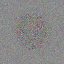

In [48]:
torchvision.transforms.ToPILImage()(res[0])

Обучаем мой AE:

In [59]:
latent_dims = 512
my_autoencoder = My_Autoencoder(latent_dims).to(device) # GPU

my_autoencoder, my_loss_list = train(my_autoencoder, data)

100%|██████████| 20/20 [20:28<00:00, 61.45s/it]


In [61]:
res = my_autoencoder.decoder(z.to(device))

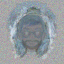

In [62]:
torchvision.transforms.ToPILImage()(res[0])

Сравнение архитектур (судя по лоссу улучшить модель удалось. todo: Нужно бы ещё разбить на train и test и посмотреть что получается там):

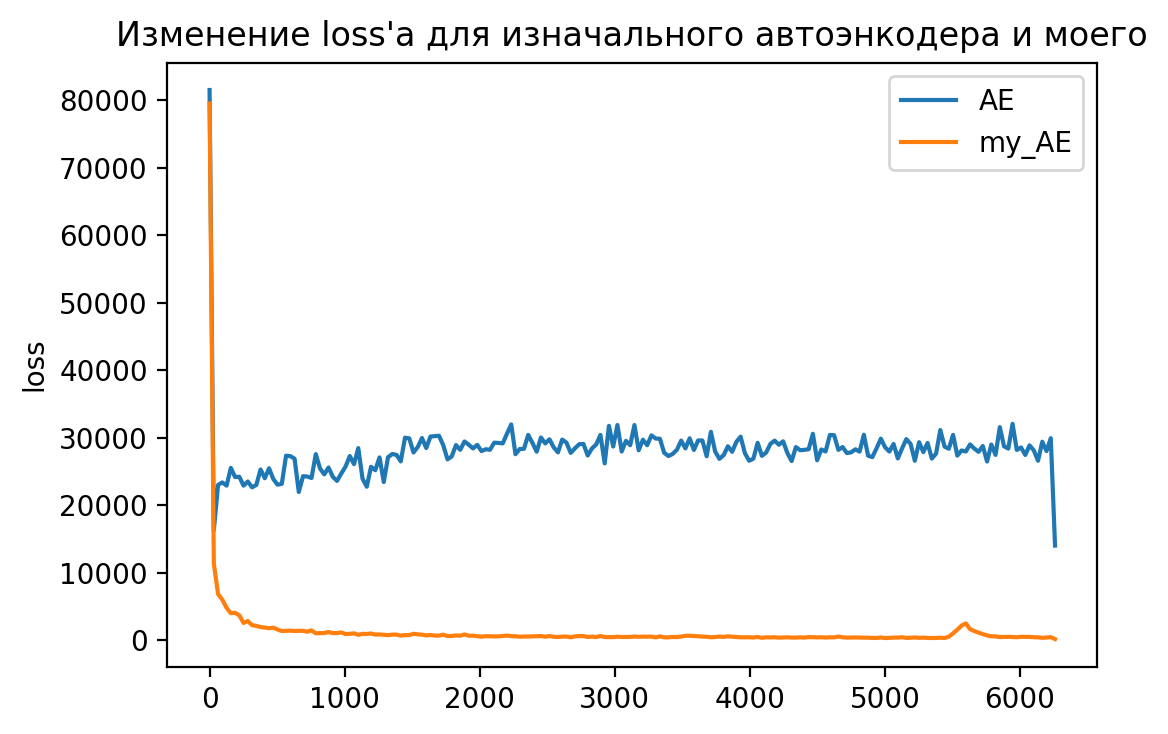

In [100]:
from scipy.interpolate import make_interp_spline

y =  np.array(loss_list)
x = np.arange(len(loss_list))
 
X_Y_Spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 200)
Y_ = X_Y_Spline(X_)
 
my_y = np.array(my_loss_list)
X_my_Y_Spline = make_interp_spline(x, my_y)
X_ = np.linspace(x.min(), x.max(), 200)
my_Y_ = X_my_Y_Spline(X_)

# Plotting the Graph
plt.plot(X_, Y_, label='AE')
plt.plot(X_, my_Y_, label = 'my_AE')
plt.title("Изменение loss'а для изначального автоэнкодера и моего")
plt.legend()
plt.ylabel("loss")
plt.show()

# VAE

Здесь я уже не стал сравнивать изначальный VAE со своим, а просто дополнил архитектуру сверточными слоями и batch_normalization для ускорения обучения

In [157]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        """
        Implement Variational Encoder, use whatever you want
        """
        super(VariationalEncoder, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2),
            nn.ReLU(True),
            nn.Conv2d(16, 64, 3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 256, 2, stride=2),
            nn.ReLU(True)
        )

        self.linear2 = nn.Sequential(nn.Linear(12544, 512), nn.PReLU())

        self.linear3 = nn.Linear(512, latent_dims) # mu
        self.linear4 = nn.Linear(512, latent_dims) # sigma

        self.N = torch.distributions.Normal(0, 1) # psi
        self.kl = 0 # kld

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear2(x)

        mu =  self.linear3(x)
        sigma = torch.exp(self.linear4(x))
        z = mu + sigma*self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [158]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [163]:
def train_vae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    loss_list = []
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss_list.append(loss.detach().cpu().numpy())
            loss.backward()
            opt.step()
    return autoencoder, loss_list

In [164]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae, vae_loss_list = train_vae(vae, data)


100%|██████████| 20/20 [21:27<00:00, 64.39s/it]


In [166]:
res = vae.decoder(z.to(device))

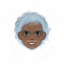

In [167]:
torchvision.transforms.ToPILImage()(res[0])

In [74]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu')

    w = 64
    img = np.zeros((w, n*w, 3))
    for i, x_hat in enumerate(interpolate_list):
        print(x_hat.shape)
        img[:, i*w:(i+1)*w] = np.array(torchvision.transforms.ToPILImage()(x_hat)) / 255
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [244]:
x, y = next(data.__iter__()) 
x_1 = x[0].unsqueeze(0).to(device) 
x_2 = x[1].unsqueeze(0).to(device) 

# Compare AE and VAE Interpolations
- Which is better? 
- Why? 
- Ответ буду читац глазами, лучше подкрепить картинками и объяснениями

Для задач генерации лучше подходит вариационный автоэнкодер, так как пространство, генерируемое с помощью VAE более непрерывное и менее разреженное):

Во-первых, это видно на примере генерации случайной картинки из скрытого пространства:

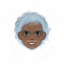

In [169]:
# Вот как справляется VAE
res = vae.decoder(z.to(device))
torchvision.transforms.ToPILImage()(res[0])

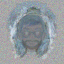

In [237]:
# А вот как не справляется AE
res = my_autoencoder.decoder(z.to(device))
torchvision.transforms.ToPILImage()(res[0])

Во-вторых, это видно при интерполяции. У VAE можно наблюдать более плавный переход от одной картинки к другой (цвета переливаются плавнее). Ещё, мне кажется наглядным пример с очками: AE на промежуточных картинках сохраняет очки в виде темных пятен, а у VAE они практически 'либо есть либо нет'. То есть промежуточные картинки у VAE более реалистичные

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


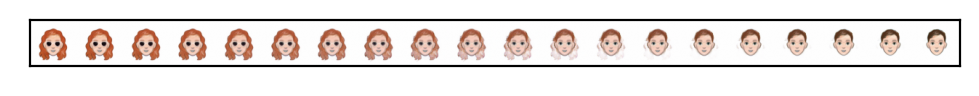

In [245]:
interpolate(my_autoencoder, x_1, x_2, n=20)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


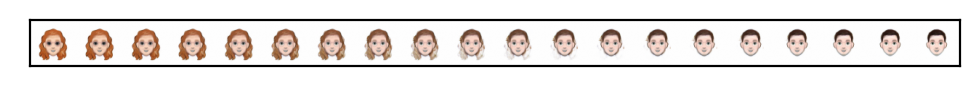

In [246]:
interpolate(vae, x_1, x_2, n=20)

Хотя обычный автоэнкодер не подходит для генеративных задач, зато восстанавливает входные картинки из скрытого пространства он с большей точностью. Ну и loss при обучении у AE меньше 


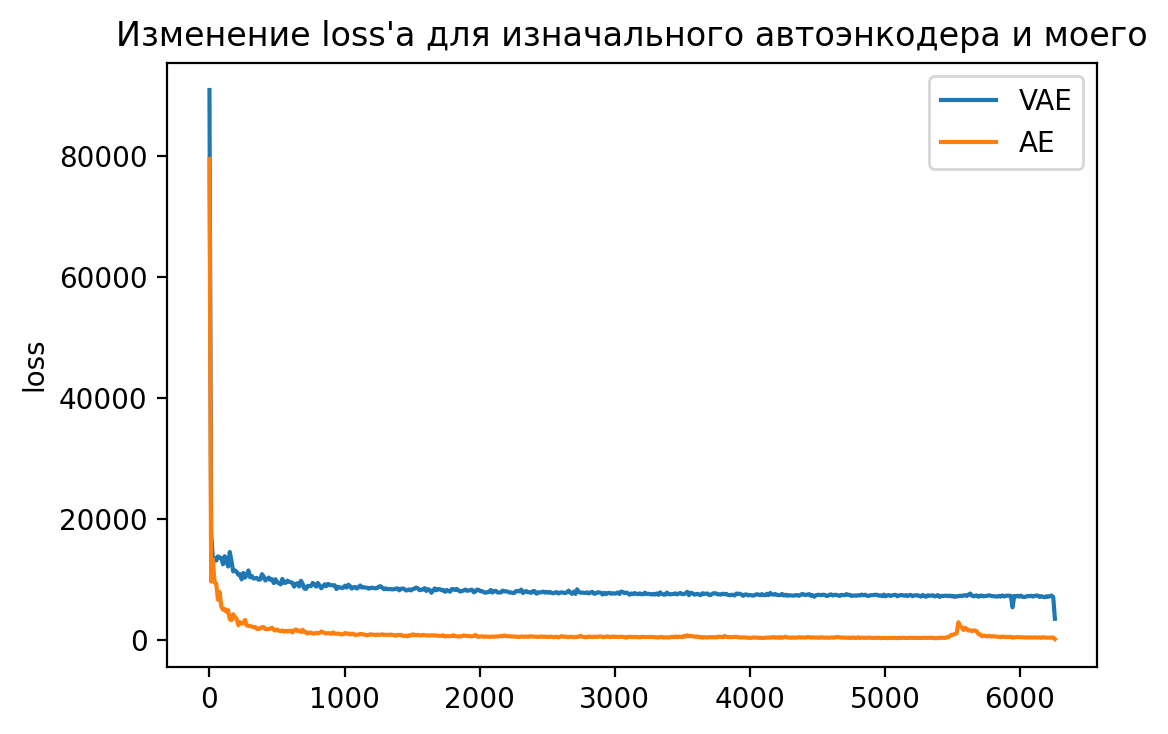

In [197]:
from scipy.interpolate import make_interp_spline

y =  np.array(vae_loss_list)
x = np.arange(len(vae_loss_list))
 
X_Y_Spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
 
my_y = np.array(my_loss_list)
X_my_Y_Spline = make_interp_spline(x, my_y)
X_ = np.linspace(x.min(), x.max(), 500)
my_Y_ = X_my_Y_Spline(X_)

# Plotting the Graph
plt.plot(X_, Y_, label='VAE')
plt.plot(X_, my_Y_, label = 'AE')
plt.title("Изменение loss'а для изначального автоэнкодера и моего")
plt.legend()
plt.ylabel("loss")
plt.show()